In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

# Load pre-processed Perturbseq experiment from hdf5

Populations are constructed in notebook *GI generate populations*

In [2]:
pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/final_single_cell_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 32.1122848988s.
Done.


In [3]:
pop.info()

Matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: int32(24665)
memory usage: 8.6 GB

Normalized matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: float64(24665)
memory usage: 17.2 GB


In [4]:
control_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/control_pop.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 2.56554293633s.
Done.


In [5]:
mean_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/mean_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.192730903625s.
Done.


# Load emap information

In [6]:
# these have different names in the emap and in GChr38
name_replacer = {'C3orf72': 'FOXL2NB',
                 'C19orf26': 'CBARP',
                 'KIAA1804': 'RP5-862P8.2',
                 'RHOXF2': 'RHOXF2B',
                }

inverse_name_replacer = {v: k for k, v in name_replacer.iteritems()}

In [7]:
emap = pd.read_csv('./final_emaps/processed_emap.csv', index_col=[0])
phen_matrix = pd.read_csv('./final_emaps/processed_fitnesses.csv', index_col=[0])
single_phen = pd.read_csv('./final_emaps/single_fitnesses.csv', index_col=[0])

In [8]:
# this is average fitness across two guides in primary emap, not single guide used for perturbseq
single_fitnesses = single_phen['average_fitness']

# fitness mapper, maps names to raw fitness values
fitness_mapper = dict()
for perturbation in pop.cells['guide_target'].unique():
    first, second = perturbation.split('_')
    try:
        if 'NegCtrl' in second:
            fitness_mapper[perturbation] = single_fitnesses.loc[first]
        elif 'NegCtrl' in first:
            fitness_mapper[perturbation] = single_fitnesses.loc[second]
        else:
            fitness_mapper[perturbation] = phen_matrix.loc[first, second]
    except KeyError:
        fitness_mapper[perturbation] = np.nan

In [9]:
single_genes = np.intersect1d(reduce(np.union1d, mean_pop.cells.query('num_targets == 1')['guide_target'].map(lambda x: x.split('_'))),
               emap.columns.map(lambda x: name_replacer.get(x, x)))
# we know these don't work...
single_genes = np.setdiff1d(single_genes, ['BAK1', 'BCL2L11'])

# maps gene name to single (SLC38A2 is the lone exception where we don't have it in position 1)
single_gene_perturbations = dict()

for gene in single_genes:
    if gene + '_NegCtrl0' in mean_pop.cells.index:
        single_gene_perturbations[gene] = gene + '_NegCtrl0'
    elif 'NegCtrl0_' + gene in mean_pop.cells.index:
        single_gene_perturbations[gene] = 'NegCtrl0_' + gene
        
double_perturbations = mean_pop.cells.query('num_targets == 2').index
perturbations = single_gene_perturbations.values()

for p in double_perturbations:
    gene1, gene2 = p.split('_')
    if gene1 in single_genes and gene2 in single_gene_perturbations.keys():
        perturbations.append(p)
        
fitnesses = mean_pop.cells.loc[perturbations, 'fitness']

mapper = {v: k for k, v in single_gene_perturbations.iteritems()}

In [10]:
# regr_fits = pd.read_csv('./data_sharing/regr_fits_final.csv', index_col=0)

In [11]:
def figure_styles():

    sns.set(font_scale=1.)

    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 18

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    sns.set_style('white')

figure_styles()

# Fitting linear epistasis model

In [12]:
from sklearn.linear_model import LinearRegression, TheilSenRegressor

def get_model(first, second, double, variable_genes, matrix):
    out = dict()
    
    singles_expr = matrix.loc[[first, second], variable_genes].T.values
    first_expr = matrix.loc[first, variable_genes].values.reshape(-1, 1)
    second_expr = matrix.loc[second, variable_genes].values.reshape(-1, 1)
    double_expr = matrix.loc[double, variable_genes].values.reshape(-1, 1)
    
    ts = TheilSenRegressor(fit_intercept=False,
                          max_subpopulation=1e5,
                          max_iter=1000,
                          random_state=1000)
    
    X = singles_expr
    y = double_expr
    ts.fit(X, y.ravel())
    
    return ts

def get_model_predictions(first, second, double, variable_genes):
    out = dict()
    
    singles_expr = matrix.loc[[first, second], variable_genes].T.values
    first_expr = matrix.loc[first, variable_genes].values.reshape(-1, 1)
    second_expr = matrix.loc[second, variable_genes].values.reshape(-1, 1)
    double_expr = matrix.loc[double, variable_genes].values.reshape(-1, 1)
    
    regr = LinearRegression(fit_intercept=False)
    ts = TheilSenRegressor(fit_intercept=False,
                          max_subpopulation=1e5,
                          max_iter=1000,
                          random_state=1000)    
    X = singles_expr
    y = double_expr
    regr.fit(X, y)
    ts.fit(X, y.ravel())
    Z = regr.predict(X)
    Zts = ts.predict(X)
    
    out['name'] = double
    out['pred'] = pd.Series(Z.flatten(), index=variable_genes, name=double)
    out['ts_pred'] = pd.Series(Zts.flatten(), index=variable_genes, name=double)
    out['first_expr'] = pd.Series(first_expr.flatten(), index=variable_genes, name=double)
    out['second_expr'] = pd.Series(second_expr.flatten(), index=variable_genes, name=double)
    out['double_expr'] = pd.Series(double_expr.flatten(), index=variable_genes, name=double)

    return out

In [13]:
ks, ps, adj_ps = ks_de(pop,
                       key='guide_target',
                       control_cells='perturbed == "control"',
                       genes='mean > 0.5',
                       normalized=True,
                       alpha=0.001,
                       n_jobs=24)

7353 control cells
groupby: index in @key_barcodes (key = guide_target)


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:    7.5s
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:   11.0s
[Parallel(n_jobs=24)]: Done  37 tasks      | elapsed:   15.7s
[Parallel(n_jobs=24)]: Done  50 tasks      | elapsed:   22.4s
[Parallel(n_jobs=24)]: Done  65 tasks      | elapsed:   29.1s
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed:   35.9s
[Parallel(n_jobs=24)]: Done  97 tasks      | elapsed:   45.8s
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:   54.0s
[Parallel(n_jobs=24)]: Done 133 tasks      | elapsed:  1.0min
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:  1.1min
[Parallel(n_jobs=24)]: Done 173 tasks      | elapsed:  1.2min
[Parallel(n_jobs=24)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=24)]: Done 217 tasks      | elapsed:  1.5min
[Parallel(n_jobs=24)]: Done 240 tasks      | elapsed:  1.6min
[Parallel(n_jobs=24)]: Done 269 out of 287 | elapsed:  1.8min remainin

Choose genes that are used for fitting linear model ("abundant" genes = mean expression > 0.5). We then only fit the model to perturbations where doubly perturbed cells have at least 10 differentially expressed genes abundant genes.

In [14]:
perturbation_ids = pop.gene_ids(np.union1d(mean_pop.cells['first_target'], mean_pop.cells['second_target']))
abundant_genes = np.setdiff1d(pop.genes.query('mean > 0.5').index.values, perturbation_ids)

doubles = list()
for idx, row in mean_pop.cells.loc[perturbations].query('num_targets == 2').iterrows():
    first = row['first_target'] + '_NegCtrl0'
    second = 'NegCtrl0_' + row['second_target']
    if (first in mean_pop.cells.index) and (second in mean_pop.cells.index):
        doubles.append((first, second, idx))

# only fit when double has more than 10 differentially expressed genes (very permissive)
# this will incidentally remove BCL2L11 and BAK1 doubles which we know are broken
gene_lists = [(first, second, double, abundant_genes) for first, second, double in doubles
               if ((adj_ps[double] < 0.001).sum() > 10)]

Regenerate linear epistasis model predictions

In [15]:
from joblib import Parallel, delayed

matrix = mean_pop.normalized_matrix

pred_data = Parallel(n_jobs=24, verbose=10)(delayed(get_model_predictions)(*double) for double in gene_lists)

[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:   13.9s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:   15.1s
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:   15.6s
[Parallel(n_jobs=24)]: Done  37 tasks      | elapsed:   28.1s
[Parallel(n_jobs=24)]: Done  50 tasks      | elapsed:   38.3s
[Parallel(n_jobs=24)]: Done  65 tasks      | elapsed:   41.1s
[Parallel(n_jobs=24)]: Done  91 out of 125 | elapsed:   53.6s remaining:   20.0s
[Parallel(n_jobs=24)]: Done 104 out of 125 | elapsed:  1.1min remaining:   12.9s
[Parallel(n_jobs=24)]: Done 117 out of 125 | elapsed:  1.1min remaining:    4.6s
[Parallel(n_jobs=24)]: Done 125 out of 125 | elapsed:  1.2min finished


Global variables used by some of the plotting routines below

In [16]:
preds = pd.DataFrame([pred['pred'] for pred in pred_data])
ts_preds = pd.DataFrame([pred['ts_pred'] for pred in pred_data])
first_exprs = pd.DataFrame([pred['first_expr'] for pred in pred_data])
second_exprs = pd.DataFrame([pred['second_expr'] for pred in pred_data])
double_exprs = pd.DataFrame([pred['double_expr'] for pred in pred_data])

# Plotting routines for comparing expression in singles and double

In [17]:
from dcor import distance_correlation

def compare_singles_to_double(double, limits=[-2, 2], figsize=[3, 3], plot_perfect=False):
    first, second = double.split('_')

    plt.figure(figsize=figsize)
    plt.axis('equal')
    s1 = plt.scatter(first_exprs.loc[double],
                     double_exprs.loc[double],
                     s=10, alpha=0.3, color='#566573')
    s2 = plt.scatter(second_exprs.loc[double],
                     double_exprs.loc[double],
                     s=10, alpha=0.3)
    plt.plot(limits, limits, color='grey', zorder=0, ls='-')
    if plot_perfect:
        l, = plt.plot(np.asarray(limits), 2.*np.asarray(limits), color='grey', zorder=0, ls='--')
    plt.xlim(limits)
    plt.ylim(limits)
    
    if plot_perfect:
        plt.legend([s1, s2, l], [first, second, 'perfect additive'])
    else:
        plt.legend([s1, s2], [first, second])

    plt.xlabel('single')
    plt.ylabel(' / '.join(double.split('_')) + ' double')
    plt.title(' / '.join(double.split('_')))
    
def compare_double_to_model(double, limits=[-2,2], model_type='ts', figsize=[3,3], s=5):
    first, second = double.split('_')

    if model_type == 'ts':
        pred = ts_preds.loc[double]
    elif model_type == 'regression':
        pred = preds.loc[double]  
    elif model_type == 'additive':
        pred = first_exprs.loc[double] + second_exprs.loc[double]
    
    plt.figure(figsize=figsize)
    plt.axis('equal')
    s1 = plt.scatter(pred,
                     double_exprs.loc[double],
                     s=s, alpha=0.3, color='#566573')
    plt.plot(limits, limits, color='grey', zorder=0, ls='-')
    plt.xlim(limits)
    plt.ylim(limits)

    plt.xlabel('c1(' + first + ') + c2(' + second + ')')
    plt.ylabel(' / '.join(double.split('_')) + ' double')
    plt.title(' / '.join(double.split('_')))
    print(pred.corr(double_exprs.loc[double]))
    print(distance_correlation(pred.values.reshape(-1, 1), double_exprs.loc[double].values.reshape(-1, 1)))
    
def compare_singles(double, limits=[-2, 2]):
    first, second = double.split('_')

    plt.figure(figsize=[3,3])
    plt.axis('equal')
    s1 = plt.scatter(first_exprs.loc[double],
                     second_exprs.loc[double],
                     s=10, alpha=0.3, color='#566573')
    plt.plot(limits, limits, color='grey', zorder=0, ls='-')
    plt.xlim(limits)
    plt.ylim(limits)

    plt.xlabel(first)
    plt.ylabel(second)
    plt.title(' / '.join(double.split('_')))

def get_model(mean_pop, double, variable_genes):
    first, second = double.split('_')
    first_id = first + '_NegCtrl0'
    second_id = 'NegCtrl0_' + second
    chosen_perturbations = [first_id, second_id, double]
    
    matrix = mean_pop.where(cells='index in @chosen_perturbations',
                            genes=variable_genes,
                            normalized=True,
                            chosen_perturbations=chosen_perturbations)
    
    singles_expr = matrix.loc[[first_id, second_id], variable_genes].T.values
    double_expr = matrix.loc[double, variable_genes].values.reshape(-1, 1)
    
    ts = TheilSenRegressor(fit_intercept=False,
                          max_subpopulation=1e5,
                          max_iter=1000,
                          random_state=1000)
    
    X = singles_expr
    y = double_expr
    ts.fit(X, y.ravel())
    
    return ts

def double_predicted_expression(mean_pop, double, genes, model_fit_genes, additive_model=False, include_difference=True):
    first, second = double.split('_')
    first_id = first + '_NegCtrl0'
    second_id = 'NegCtrl0_' + second
    chosen_perturbations = [first_id, second_id, double]
    
    mean_expr = mean_pop.where(cells=chosen_perturbations,
                          genes=genes,
                          normalized=True,
                          gene_names=True)
    
    if additive_model:
        mean_expr.loc['additive prediction'] = mean_expr.loc[first_id] + mean_expr.loc[second_id]
        if include_difference:
            mean_expr.loc['difference'] = mean_expr.loc[double] - mean_expr.loc['additive prediction']
    else:
        ts = get_model(mean_pop, double, model_fit_genes)
        mean_expr.loc['model prediction'] = pd.Series(ts.predict(mean_expr.loc[[first_id, second_id]].T),
                                        index=mean_expr.columns)
        if include_difference:
            mean_expr.loc['difference'] = mean_expr.loc[double] - mean_expr.loc['model prediction']
    
    return mean_expr

def double_subpop(pop, double, balance_representation=True, include_control_cells=False):
    first, second = double.split('_')
    first_id = first + '_NegCtrl0'
    second_id = 'NegCtrl0_' + second
    chosen_perturbations = [first_id, second_id, double]
    
    if balance_representation:
        min_cell_number = mean_pop.cells.query('guide_target in @chosen_perturbations')['num_cells'].min()
        first_cells = pop.cells.query('guide_target == @first_id').sample(n=min_cell_number, replace=False, random_state=100).index
        second_cells = pop.cells.query('guide_target == @second_id').sample(n=min_cell_number, replace=False, random_state=100).index
        double_cells = pop.cells.query('guide_target == @double').sample(n=min_cell_number, replace=False, random_state=100).index
        if include_control_cells:
            control_cells = control_pop.cells.sample(n=min_cell_number, replace=False, random_state=100).index
        else:
            control_cells = []
        chosen_cells = reduce(np.union1d, [first_cells, second_cells, double_cells, control_cells])
    else:
        chosen_cells = pop.cells.query('guide_target in @chosen_perturbations').index
        
    subpop = pop.subpopulation(cells='index in @chosen_cells',
                           normalized_matrix='inherit',
                           chosen_cells=chosen_cells)
    return subpop

def double_variable_expression(pop, double, test_genes, model_fit_genes, num_features=100, balance_representation=True, include_difference=True, additive_model=False, include_control_cells=False):
    first, second = double.split('_')
    
    subpop = double_subpop(pop, double, balance_representation=balance_representation, include_control_cells=include_control_cells)
    
    control_targets = control_pop.cells['guide_target'].unique()
    subpop.cells['perturbation'] = subpop.cells['guide_target'].map(lambda x: 'control' if x in control_targets else x)
    
    res = tree_selector(subpop,
                    'perturbation',
                    num_features=num_features,
                    genes=test_genes,
                    normalized=True,
                    dropna=True,
                    ignore=pop.gene_ids([first, second]),
                    clf='extra',
                    n_jobs=32,
                    random_state=100,
                    )
    
    mean_expr = double_predicted_expression(mean_pop,
                                            double,
                                            res.selected_genes,
                                            model_fit_genes,
                                            additive_model=additive_model,
                                            include_difference=include_difference)
    return mean_expr

def double_variable_expression_heatmap(pop, double, test_genes, model_fit_genes, num_features=100, include_model=True, include_difference=True, balance_representation=True, additive_model=False, figsize=[8,3], square=False, quantiles=[0.03, 0.97], vmin=None, vmax=None, col_linkage=None, include_control_cells=False):
    mean_expr = double_variable_expression(pop,
                                           double,
                                           test_genes=test_genes,
                                           model_fit_genes=model_fit_genes,
                                           num_features=num_features,
                                           balance_representation=balance_representation,
                                           additive_model=additive_model,
                                           include_control_cells=include_control_cells,
                                           include_difference=include_difference)
    
    
    if vmin is None and vmax is None:
        quantile_range = np.max(np.abs(mean_expr.stack().quantile(quantiles)))
        vmin = -quantile_range
        vmax = quantile_range
    
    if not include_model:
        mean_expr = mean_expr.iloc[0:3]
    
    mean_expr.index = mean_expr.index.str.replace('_', ' / ').str.replace('NegCtrl0', 'ctrl')
    
    if col_linkage is None:
        cg = sns.clustermap(mean_expr,
                           figsize=figsize,
                           method='ward',
                           row_cluster=False,
                           cmap=plt.cm.get_cmap('RdBu_r'),
                           vmin=vmin, vmax=vmax,
                           square=square,
                           xticklabels=True)
    else:
        cg = sns.clustermap(mean_expr,
                           figsize=figsize,
                           col_linkage=col_linkage,
                           row_cluster=False,
                           cmap=plt.cm.get_cmap('RdBu_r'),
                           vmin=vmin, vmax=vmax,
                           square=square,
                           xticklabels=True)
    return mean_expr, cg

from umap import UMAP

def double_umap(pop, double, genes, num_features=100, balance_representation=True, figsize=[3,3], metric='correlation', include_control_cells=False, use_pca=False, s=10):
    first, second = double.split('_')
    first_id = first + '_NegCtrl0'
    second_id = 'NegCtrl0_' + second

    subpop = double_subpop(pop, double, include_control_cells=include_control_cells)
    control_targets = control_pop.cells['guide_target'].unique()
    subpop.cells['perturbation'] = subpop.cells['guide_target'].map(lambda x: 'control' if x in control_targets else x)

    res = tree_selector(subpop,
                'perturbation',
                num_features=num_features,
                genes=genes,
                normalized=True,
                dropna=True,
                ignore=pop.gene_ids([first, second]),
                clf='extra',
                n_jobs=32,
                random_state=100,
                )

    mapper = {first_id: 'lightslategray',
             double: 'darkorange',
             second_id: 'navy',
             'control': 'palevioletred'}

    transformer = PCAUMAPReducer(n_neighbors=10, metric=metric, random_state=100, use_pca=use_pca)
    coords = subpop.fit_transform(transformer,
                             genes=res.selected_genes,
                             normalized=True,
                             prefix='UMAP')
    coords['perturbation'] = subpop.cells['perturbation']
    
    plt.figure(figsize=figsize)
    for perturbation in subpop.cells['perturbation'].unique():
        plt.scatter(coords.query('perturbation == "{0}"'.format(perturbation))['UMAP0'],
                coords.query('perturbation == "{0}"'.format(perturbation))['UMAP1'],
                c=mapper[perturbation], alpha=0.5, s=s, label=perturbation)
    plt.axis('off');
    plt.legend();

# Perturbation UMAPs

Differential expression is determined by training a random forest classifier to distinguish cells from the different genetic backgrounds based on gene expression. The most informative genes for classification will naturally be reproducibly variable across conditions. The classification accuracy is a natural guage for how different cells behave across the different genetic backgrounds. The variable genes are then used in UMAP projections. 

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Training (genes: mean > 0.5)...
Using 748 estimators for 2803 features...
Feature prediction accuracy (test size: 20.0%): 0.703045685279

                precision    recall  f1-score   support

    DUSP9_ETS2       0.72      0.33      0.46       132
DUSP9_NegCtrl0       0.60      0.83      0.70       131
 NegCtrl0_ETS2       0.82      0.95      0.88       131

     micro avg       0.70      0.70      0.70       394
     macro avg       0.71      0.70      0.68       394
  weighted avg       0.71      0.70      0.68       394

Picked 200 features.
Using 200 estimators for 200 features...
Feature prediction accuracy (test size: 20.0%): 0.761421319797

                precision    recall  f1-score   support

    DUSP9_ETS2       0.71      0.61      0.66       132
DUSP9_NegCtrl0       0.72      0.76      0.74       131
 NegCtrl0_ETS2       0.85      0.92      0.88       131

     micro avg       0.76      0

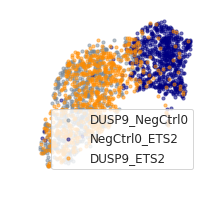

In [18]:
double_umap(pop, 'DUSP9_ETS2', genes='mean > 0.5', num_features=200, metric='euclidean')
plt.savefig('./figures/single_cell_ordering_dusp9_ets2_umap.pdf')

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Training (genes: mean > 0.5)...
Using 758 estimators for 2877 features...
Feature prediction accuracy (test size: 20.0%): 0.845637583893

                precision    recall  f1-score   support

   DUSP9_MAPK1       0.89      0.66      0.76        50
DUSP9_NegCtrl0       0.89      0.96      0.92        49
NegCtrl0_MAPK1       0.78      0.92      0.84        50

     micro avg       0.85      0.85      0.85       149
     macro avg       0.85      0.85      0.84       149
  weighted avg       0.85      0.85      0.84       149

Picked 200 features.
Using 200 estimators for 200 features...
Feature prediction accuracy (test size: 20.0%): 0.879194630872

                precision    recall  f1-score   support

   DUSP9_MAPK1       0.92      0.72      0.81        50
DUSP9_NegCtrl0       0.89      1.00      0.94        49
NegCtrl0_MAPK1       0.84      0.92      0.88        50

     micro avg       0.88      0

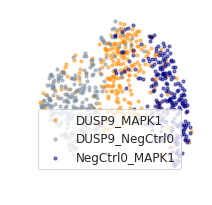

In [19]:
double_umap(pop, 'DUSP9_MAPK1', genes='mean > 0.5', num_features=200, metric='euclidean')
plt.savefig('./figures/single_cell_ordering_dusp9_mapk1_umap.pdf')

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Training (genes: mean > 0.5)...
Using 741 estimators for 2746 features...
Feature prediction accuracy (test size: 20.0%): 0.635555555556

                precision    recall  f1-score   support

    ETS2_MAPK1       0.64      0.80      0.71        75
 ETS2_NegCtrl0       0.65      0.64      0.64        75
NegCtrl0_MAPK1       0.61      0.47      0.53        75

     micro avg       0.64      0.64      0.64       225
     macro avg       0.63      0.64      0.63       225
  weighted avg       0.63      0.64      0.63       225

Picked 200 features.
Using 200 estimators for 200 features...
Feature prediction accuracy (test size: 20.0%): 0.622222222222

                precision    recall  f1-score   support

    ETS2_MAPK1       0.67      0.68      0.68        75
 ETS2_NegCtrl0       0.64      0.63      0.63        75
NegCtrl0_MAPK1       0.56      0.56      0.56        75

     micro avg       0.62      0

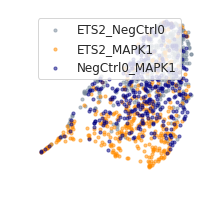

In [20]:
double_umap(pop, 'ETS2_MAPK1', genes='mean > 0.5', num_features=200, metric='euclidean')
plt.savefig('./figures/single_cell_ordering_ets2_mapk1_umap.pdf')

# Expression heatmaps

Use a similar random forest classifier approach to above but now directly visualized the genes across conditions, together with the model fits from the linear interaction model.

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Training (genes: mean > 0.5)...
Using 758 estimators for 2877 features...
Feature prediction accuracy (test size: 20.0%): 0.845637583893

                precision    recall  f1-score   support

   DUSP9_MAPK1       0.89      0.66      0.76        50
DUSP9_NegCtrl0       0.89      0.96      0.92        49
NegCtrl0_MAPK1       0.78      0.92      0.84        50

     micro avg       0.85      0.85      0.85       149
     macro avg       0.85      0.85      0.84       149
  weighted avg       0.85      0.85      0.84       149

Picked 100 features.
Using 141 estimators for 100 features...
Feature prediction accuracy (test size: 20.0%): 0.872483221477

                precision    recall  f1-score   support

   DUSP9_MAPK1       0.86      0.74      0.80        50
DUSP9_NegCtrl0       0.90      0.96      0.93        49
NegCtrl0_MAPK1       0.85      0.92      0.88        50

     micro avg       0.87      0

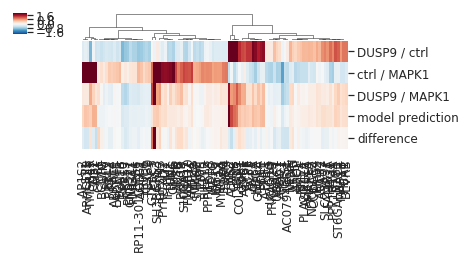

In [21]:
dusp9_mapk1_expr, cg = double_variable_expression_heatmap(pop,
                                                       'DUSP9_MAPK1',
                                                       test_genes='mean > 0.5',
                                                       model_fit_genes=abundant_genes,
                                                       figsize=[6, 2.5])
cg.savefig('./figures/single_cell_ordering_dusp9_mapk1_heatmap.pdf')

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Training (genes: mean > 0.5)...
Using 748 estimators for 2803 features...
Feature prediction accuracy (test size: 20.0%): 0.703045685279

                precision    recall  f1-score   support

    DUSP9_ETS2       0.72      0.33      0.46       132
DUSP9_NegCtrl0       0.60      0.83      0.70       131
 NegCtrl0_ETS2       0.82      0.95      0.88       131

     micro avg       0.70      0.70      0.70       394
     macro avg       0.71      0.70      0.68       394
  weighted avg       0.71      0.70      0.68       394

Picked 100 features.
Using 141 estimators for 100 features...
Feature prediction accuracy (test size: 20.0%): 0.771573604061

                precision    recall  f1-score   support

    DUSP9_ETS2       0.73      0.64      0.69       132
DUSP9_NegCtrl0       0.72      0.74      0.73       131
 NegCtrl0_ETS2       0.85      0.93      0.89       131

     micro avg       0.77      0

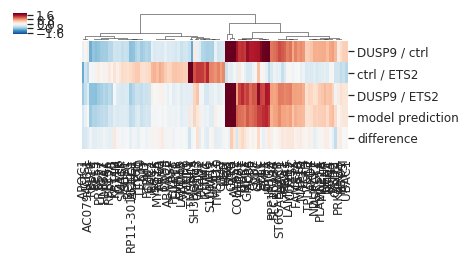

In [22]:
dusp9_ets2_expr, cg = double_variable_expression_heatmap(pop,
                                                       'DUSP9_ETS2',
                                                       test_genes='mean > 0.5',
                                                       model_fit_genes=abundant_genes,
                                                       figsize=[6, 2.5])
cg.savefig('./figures/single_cell_ordering_dusp9_ets2_heatmap.pdf')

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Training (genes: mean > 0.5)...
Using 741 estimators for 2746 features...
Feature prediction accuracy (test size: 20.0%): 0.635555555556

                precision    recall  f1-score   support

    ETS2_MAPK1       0.64      0.80      0.71        75
 ETS2_NegCtrl0       0.65      0.64      0.64        75
NegCtrl0_MAPK1       0.61      0.47      0.53        75

     micro avg       0.64      0.64      0.64       225
     macro avg       0.63      0.64      0.63       225
  weighted avg       0.63      0.64      0.63       225

Picked 100 features.
Using 141 estimators for 100 features...
Feature prediction accuracy (test size: 20.0%): 0.626666666667

                precision    recall  f1-score   support

    ETS2_MAPK1       0.67      0.71      0.69        75
 ETS2_NegCtrl0       0.64      0.64      0.64        75
NegCtrl0_MAPK1       0.56      0.53      0.55        75

     micro avg       0.63      0

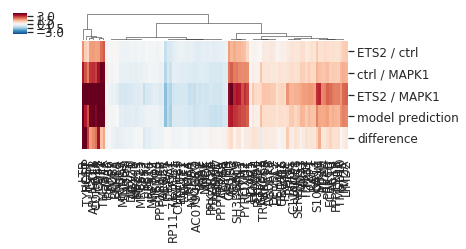

In [23]:
ets2_mapk1_expr, cg = double_variable_expression_heatmap(pop,
                                                       'ETS2_MAPK1',
                                                       test_genes='mean > 0.5',
                                                       model_fit_genes=abundant_genes,
                                                       figsize=[6, 2.5])
cg.savefig('./figures/single_cell_ordering_ets2_mapk1_heatmap.pdf')

# Principal curve analysis

In [24]:
from perturbseq.transformers import PCAUMAPReducer
from umap import UMAP
from sklearn.manifold import spectral_embedding

def get_nngraph(subpop, genes, metric='euclidean', n_neighbors=10, use_pca=False):
    # get nearest neighbor graph from UMAP, note that despite the name of the transformer
    # here we are not using PCA reduction and are just using UMAP directly
    transformer = PCAUMAPReducer(metric=metric, n_neighbors=n_neighbors, random_state=100, use_pca=use_pca)

    coords = subpop.fit_transform(transformer,
                                 genes=genes,
                                 normalized=True,
                                 prefix='UMAP')
    
    subpop.plot(coords, 'perturbation', alpha=0.5)
    
    nn_graph = pd.DataFrame(transformer.graph_.todense(),
             index=subpop.cells.index,
             columns=subpop.cells.index)
    
    # reduce nearest neighbor graph to single dimension using spectral embedding
    principal_curve = pd.Series(spectral_embedding(transformer.graph_, n_components=1).flatten(),
                            index=subpop.cells.index)
    principal_curve = principal_curve.sort_values()

    return nn_graph, principal_curve, coords

def get_principal_expression(coords, principal_curve, expr, window=25, normalize=True):
    # sort cells according to their position along principal curve
    sorted_order = principal_curve.sort_values().index

    # perform rolling average of cell X and Y position in UMAP to visualize the curve
    x_coord = coords.loc[sorted_order, 'UMAP0']
    y_coord = coords.loc[sorted_order, 'UMAP1']

    x_coord = x_coord.rolling(window=window, center=True).mean().dropna()
    y_coord = y_coord.rolling(window=window, center=True).mean().dropna()
    
    closest_expr = dict()
    pc_point = dict()

    # nearest cells in transformed space
    for bc, x in x_coord.iteritems():
        y = y_coord.loc[bc]
        dists = coords[['UMAP0', 'UMAP1']] - np.asarray([x, y])
        min_bc = (dists**2).sum(axis=1).idxmin()

        closest_expr[bc] = min_bc
        pc_point[bc] = principal_curve.loc[bc]
        
    # same cell may appear more than once as closest to principal curve
    # in that case we average its position
    df = pd.DataFrame([closest_expr, pc_point]).T
    df.columns = ['closest_cell', 'pc_dist']
    df['pc_dist'] = df['pc_dist'].astype(float)
    closest_cells = df.groupby('closest_cell').median()['pc_dist'].sort_values()

    closest_profiles = expr.loc[closest_cells.index]
    if normalize:
        closest_profiles = (closest_profiles - closest_profiles.min())/(closest_profiles.max() - closest_profiles.min())
    
    return closest_profiles, x_coord, y_coord

def get_median_expression(expr, principal_curve, window=5, normalize=True):
    # median filter expression within cells according to position along principal curve
    sorted_order = principal_curve.sort_values().index
    median_profiles = expr.loc[sorted_order].rolling(window=window, center=True).median().dropna()
    if normalize:
        median_profiles = (median_profiles - median_profiles.min())/(median_profiles.max() - median_profiles.min())
       
    # put in order and remove the profiles at the edges that are all NaN after averaging
    median_profiles = median_profiles.reindex(sorted_order).dropna()
    return median_profiles

def get_imputed_expression(subpop, genes, nn_graph):
    # simple imputation scheme that uses weights from UMAP nearest neighbor graph to smooth expression
    # expression within each cell and for each gene is replaced by a weighted average of expression
    # in its neighbors
    perturbed_genes = reduce(np.union1d, map(lambda x: x.split('_'), subpop.cells['guide_target'].unique()))
    
    expr = subpop.where(genes='index in @selected_genes or gene_name in @chosen',
                    normalized=True,
                    selected_genes=genes,
                    chosen=perturbed_genes,
                    gene_names=True)
    
    imputed_expr = dict()

    for cell, weights in nn_graph.iterrows():
        weights = weights[weights > 0]
        imputed_expr[cell] = expr.loc[weights.index].mul(weights, axis=0).sum()/weights.sum()

    imputed_expr = pd.DataFrame(imputed_expr).T
    imputed_expr = imputed_expr.loc[expr.index]
    
    return imputed_expr, expr

def local_median_filter(data, distances, window):
    filtered = dict()
    for bc, dist in distances.iteritems():
        filtered[bc] = data[(distances - dist).abs() < window].median()
    
    return pd.Series(filtered).loc[distances.sort_values().index]

def get_local_median_expression(expr, principal_curve, window, normalize=True):
    # superior version of median filtering routine above that actually takes into account distance along
    # principal curve. For each cell, other cells within a window around it along the principal curve
    # will be averaged together
    sorted_order = principal_curve.sort_values().index
    median_profiles = expr.loc[sorted_order].apply(lambda x: local_median_filter(x, principal_curve, 1e-3)).dropna()
    if normalize:
        median_profiles = (median_profiles - median_profiles.min())/(median_profiles.max() - median_profiles.min())
       
    # put in order and remove the profiles at the edges that are all NaN after averaging
    median_profiles = median_profiles.reindex(sorted_order).dropna()
    return median_profiles

Global variables below set which perturbation is being analyzed.

In [25]:
double = 'DUSP9_MAPK1'
first, second = double.split('_')
first_id = first + '_NegCtrl0'
second_id = 'NegCtrl0_' + second

chosen_perturbations = [first_id, second_id, double]

subpop = double_subpop(pop, double)

control_targets = control_pop.cells['guide_target'].unique()
subpop.cells['perturbation'] = subpop.cells['guide_target'].map(lambda x: 'control' if x in control_targets else x)

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...


Get some differentially expressed genes

In [26]:
res = tree_selector(subpop,
                    'perturbation',
                    num_features=200,
                    genes='mean > 0.5',
                    normalized=True,
                    ignore=pop.gene_ids([first, second]),
                    clf='extra',
                    n_jobs=32,
                    random_state=100,
                    )

perturbseq/differential_expression.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  matrix.drop(ignore, inplace=True, axis=1, errors='ignore')


Training (genes: mean > 0.5)...
Using 758 estimators for 2877 features...
Feature prediction accuracy (test size: 20.0%): 0.845637583893

                precision    recall  f1-score   support

   DUSP9_MAPK1       0.89      0.66      0.76        50
DUSP9_NegCtrl0       0.89      0.96      0.92        49
NegCtrl0_MAPK1       0.78      0.92      0.84        50

     micro avg       0.85      0.85      0.85       149
     macro avg       0.85      0.85      0.84       149
  weighted avg       0.85      0.85      0.84       149

Picked 200 features.
Using 200 estimators for 200 features...
Feature prediction accuracy (test size: 20.0%): 0.879194630872

                precision    recall  f1-score   support

   DUSP9_MAPK1       0.92      0.72      0.81        50
DUSP9_NegCtrl0       0.89      1.00      0.94        49
NegCtrl0_MAPK1       0.84      0.92      0.88        50

     micro avg       0.88      0.88      0.88       149
     macro avg       0.88      0.88      0.88       149
  w

Use variable genes to construct UMAP projection and extract nearest neighbor graph from UMAP

Performing UMAP...
Done.


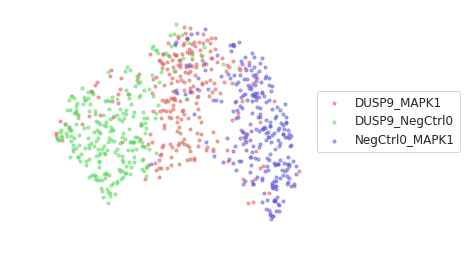

In [27]:
nn_graph, principal_curve, coords = get_nngraph(subpop, res.selected_genes, metric='euclidean', use_pca=False)

Add to subpopulation cells table

In [28]:
subpop.cells['PC0'] = principal_curve

Do simple imputation of gene expression within each cell based on that in its nearest neighors 

In [29]:
imputed_expr, expr = get_imputed_expression(subpop, res.selected_genes, nn_graph)

Get various sorts of averaged expression profiles along principal curve.

In [30]:
closest_profiles, x_coord, y_coord = get_principal_expression(coords, principal_curve, imputed_expr, window=50)
# simple rolling median average along principal curve
median_profiles = get_median_expression(imputed_expr, principal_curve, window=10, normalize=True)
# local median filter -- only averages cells together that are within a given distance
raw_local_median_profiles = get_local_median_expression(expr, principal_curve, window=2e-3, normalize=True)

Visualize principal curve

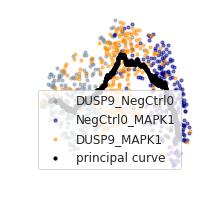

In [31]:
plt.figure(figsize=[3, 3])

mapper = {first_id: 'lightslategray',
         double: 'darkorange',
         second_id: 'navy',
         'control': 'palevioletred'}

coords['perturbation'] = subpop.cells['perturbation']

for perturbation in chosen_perturbations:
    plt.scatter(coords.query('perturbation == "{0}"'.format(perturbation))['UMAP0'],
                coords.query('perturbation == "{0}"'.format(perturbation))['UMAP1'],
                c=mapper[perturbation], alpha=0.5, s=10, label=perturbation)
plt.scatter(x_coord, y_coord, c='black', s=10, label='principal curve')
plt.axis('off');
plt.legend();
plt.savefig('./figures/single_cell_ordering_UMAP.pdf', bbox_inches='tight')

Averaged, normalized expression of genes along the curve. Expression is normalized for each gene to a 0-1 range so that differences in accumulation can be observed.

In [32]:
from matplotlib.colors import to_hex
from scipy.cluster.hierarchy import linkage

Z = linkage(raw_local_median_profiles.T, method='average', metric='correlation', optimal_ordering=True)

purple_cmapper = plt.cm.get_cmap('Purples', 20)
orange_cmapper = plt.cm.get_cmap('Oranges', 20)

first_colors = raw_local_median_profiles[first].map(lambda x: to_hex(purple_cmapper(x)))
second_colors = raw_local_median_profiles[second].map(lambda x: to_hex(orange_cmapper(x)))

dusp9_cells = subpop.cells.loc[median_profiles.index, 'perturbation'].map(lambda x: 'darkgrey' if x == 'DUSP9_NegCtrl0' else 'white')
dusp9_cells.name = 'DUSP9 / ctrl'
mapk1_cells = subpop.cells.loc[median_profiles.index, 'perturbation'].map(lambda x: 'darkgrey' if x == 'NegCtrl0_MAPK1' else 'white')
mapk1_cells.name = 'ctrl / MAPK1'
dusp9_mapk1_cells = subpop.cells.loc[median_profiles.index, 'perturbation'].map(lambda x: 'darkgrey' if x == 'DUSP9_MAPK1' else 'white')
dusp9_mapk1_cells.name = 'DUSP9 / MAPK1'

color_df = pd.DataFrame([dusp9_cells, dusp9_mapk1_cells, mapk1_cells, first_colors, second_colors]).T.loc[median_profiles.index]

In [ ]:
cg = sns.clustermap(raw_local_median_profiles, row_colors=color_df,
               method='ward', row_cluster=False,
               col_linkage=Z, robust=True, cmap=plt.cm.get_cmap('RdBu_r'),
              yticklabels=False, figsize=[10, 4])
cg.savefig('./figures/single_cell_ordering_gene_expression.pdf')

/home/tmn/.local/lib/python2.7/site-packages/seaborn/matrix.py:823: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  colors = colors.loc[data.index]


# Specific gene expression traces

In [ ]:
from matplotlib.patches import Rectangle

def plot_path(double, first_gene, second_gene, expr, principal_curve, cell_index=None,
              draw_extents=True, normalize=False, window=None, superimpose_median=False,
             figsize=[3, 3], ylim=[-0.05, 1.05]):
    plt.figure(figsize=figsize)
    if cell_index is None:
        cell_index = principal_curve.index
        
    first, second = double.split('_')
    first_id = first + '_NegCtrl0'
    second_id = 'NegCtrl0_' + second 
    
    mapper = {first_id: 'lightslategray',
             double: 'darkorange',
             second_id: 'navy',
             'control': 'palevioletred'}    
    
    if draw_extents:
        low_first, high_first = subpop.cells.query('perturbation == "{0}"'.format(first_id))['PC0'].quantile([0.1, 0.9]).values
        low_second, high_second = subpop.cells.query('perturbation == "{0}"'.format(second_id))['PC0'].quantile([0.1, 0.9]).values

        first_rect = Rectangle((low_first, ylim[0]),
                              high_first - low_first,
                              ylim[1] - ylim[0],
                              facecolor=mapper[first_id],
                              alpha=0.3)


        second_rect = Rectangle((low_second, ylim[0]),
                              high_second - low_second,
                              ylim[1] - ylim[0],
                              facecolor=mapper[second_id],
                              alpha=0.3)
        plt.gca().add_patch(first_rect)
        plt.gca().add_patch(second_rect)

    x = principal_curve.loc[cell_index]
    y1 = expr.loc[cell_index, first_gene]
    y2 = expr.loc[cell_index, second_gene]
    
    if window is not None and not superimpose_median:
        y1 = y1.rolling(window=window, center=True).median()
        y2 = y2.rolling(window=window, center=True).median()
        
    if superimpose_median:
        z1 = local_median_filter(y1, principal_curve.loc[cell_index], window=window)
        z2 = local_median_filter(y2, principal_curve.loc[cell_index], window=window)
        
    if normalize:
        y1_min, y1_max = y1.quantile([0, 1])
        y2_min, y2_max = y2.quantile([0, 1])
        y1 = (y1 - y1_min)/(y1_max - y1_min)
        y2 = (y2 - y2_min)/(y2_max - y2_min)
        
        if superimpose_median:
            z1 = (z1 - y1_min)/(y1_max - y1_min)
            z2 = (z2 - y2_min)/(y2_max - y2_min)
            
    if superimpose_median:
        alpha1 = 0.4
        alpha2 = 0.4
    else:
        alpha1 = 1
        alpha2 = 1
        
    plt.scatter(x,
                y1,
                label=first_gene,
                c=mapper[first_id], s=10, alpha=alpha1)

    plt.scatter(x,
                y2,
                label=second_gene,
                c=mapper[second_id], s=10, alpha=alpha2)
    
    if superimpose_median:
        plt.plot(x,
                    z1,
                    c=mapper[first_id], linewidth=3)    
        plt.plot(x,
                    z2,
                    c=mapper[second_id], linewidth=3)  

    plt.xlim(1.05*np.asarray([principal_curve.min(), principal_curve.max()]));
    plt.xticks([]);
    plt.xlabel('Pseudotime');
    plt.ylabel('Expression');
    plt.legend();
    plt.ylim(ylim);

In [ ]:
sorted_order = principal_curve.sort_values().index
double_cells = subpop.cells.query('perturbation == "{0}"'.format(double)).index
double_cells = pd.Series(np.arange(0, len(sorted_order)), index=sorted_order).loc[double_cells].sort_values().index
first_cells = subpop.cells.query('perturbation == "{0}"'.format(first_id)).index
first_cells = pd.Series(np.arange(0, len(sorted_order)), index=sorted_order).loc[first_cells].sort_values().index
second_cells = subpop.cells.query('perturbation == "{0}"'.format(second_id)).index
second_cells = pd.Series(np.arange(0, len(sorted_order)), index=sorted_order).loc[second_cells].sort_values().index
non_double_cells = subpop.cells.query('perturbation != "{0}"'.format(double)).index
non_double_cells = pd.Series(np.arange(0, len(sorted_order)), index=sorted_order).loc[non_double_cells].sort_values().index

This is showing the accumulation (so expression normalized to 0-1 range) of two highly expressed marker genes (so relatively well detected and differences are likely to be significant)

In [ ]:
plot_path('DUSP9_MAPK1',
         'HBZ',
         'GYPA',
         raw_local_median_profiles,
         principal_curve,)
plt.savefig('./figures/single_cell_ordering_hbz_vs_gypa_scatter.pdf', bbox_inches='tight')

This is looking directly at the expression of the perturbed genes (MAPK1/DUSP9) within only doubly perturbed cells. The goal here is to see whether cells lying at different points on the principal curve have different properties. Because the expression is relatively flat, the apparent differences in phenotype (which result in different locations in the UMAP and principal curve) are not likely due to stable differences in activation level.

In [ ]:
plot_path('DUSP9_MAPK1',
         'DUSP9',
         'MAPK1',
         expr,
         principal_curve,
         cell_index=double_cells,
         normalize=False,
         window=2e-3, superimpose_median=True, figsize=[3, 3], ylim=[-5, 20])
plt.savefig('./figures/single_cell_ordering_dusp9_mapk1_expression_double_cells.pdf')